# Packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pycountry
import plotly.express as px
import plotly.graph_objs as go
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
pyo.init_notebook_mode()
# %matplotlib inline

# Read Data

In [ ]:
data = pd.read_csv('/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv', skiprows=1)

# Data sanity check and preparation

In [ ]:
# Check dimension of the data
print('Dimensions of the dataframe: ', data.shape) 
print('Total no. of participants: ', data.shape[0])

# drop the first column
data = data.drop('Duration (in seconds)', axis=1)

# rename the columns
new_names = ['Age','Gender','Country','Education','Current/Recent Title','Years of Coding',
            'Python','R','SQL','C','C++','Java','Javascript','Julia','Swift','Bash','MATLAB','None','Other',
            'Recommended Languages',
            'Jupyter Products','RStudio','Visual_Studio','VSCode','PyCharm','Spyder','Notepad','Sublime','Vim/emacs','Matlab','None','Other',
            'Kaggle','Colab','Azure','Paperspace','Binder','Code Ocean','IBM Watson','Amazon_Sagemaker','Amazon_EMR','Google Cloud AI','Google Cloud Datalab',
            'Databricks','None','Other',
            'Computing Platform',
            'GPU','TPU','None','Other',
             'TPU Used times',
             'Matplotlib','Seaborn','Plotly/Plotly Express','Ggplot/ggplot2','Shiny','D3','Altair','Bokeh','Geoplotlib','Leaflet/Folium','None','Other']
            
data.rename(columns=dict(zip(data.columns[list(range(0, 65))], new_names)), inplace=True)

# print the column names
print(list(data.columns))

# # Check if the first 3 columns (age, gender, Country) contain Nan, the rest can have Nan values
display(data.isnull().sum())

# # Check unique country names
data.Country.unique()

# Participation by Gender
* Chart - Participation by Gender: Shows the huge gender gap between men and women taking part in Kaggle competitions

In [ ]:
# group by gender
gender_data = data['Gender'].value_counts()
total_participants = gender_data.sum()
gender_data = round((gender_data/total_participants)*100,1)

# plot gender data
gender_data.plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6), figsize=(9,5), rot=30)
plt.xlabel("Gender", labelpad=14)
plt.ylabel("Count of People by gender", labelpad=15)
plt.title('Gap between Men and women: {}%'.format(round(gender_data.iloc[0]-gender_data.iloc[1],1)), y=1)
plt.suptitle('Participation by Gender', y=1)    
plt.show()

# Participation by Countries
* Chart - Participation by Countries: India tops the list in number of participants somewhat followed by the USA and the rest are minorities
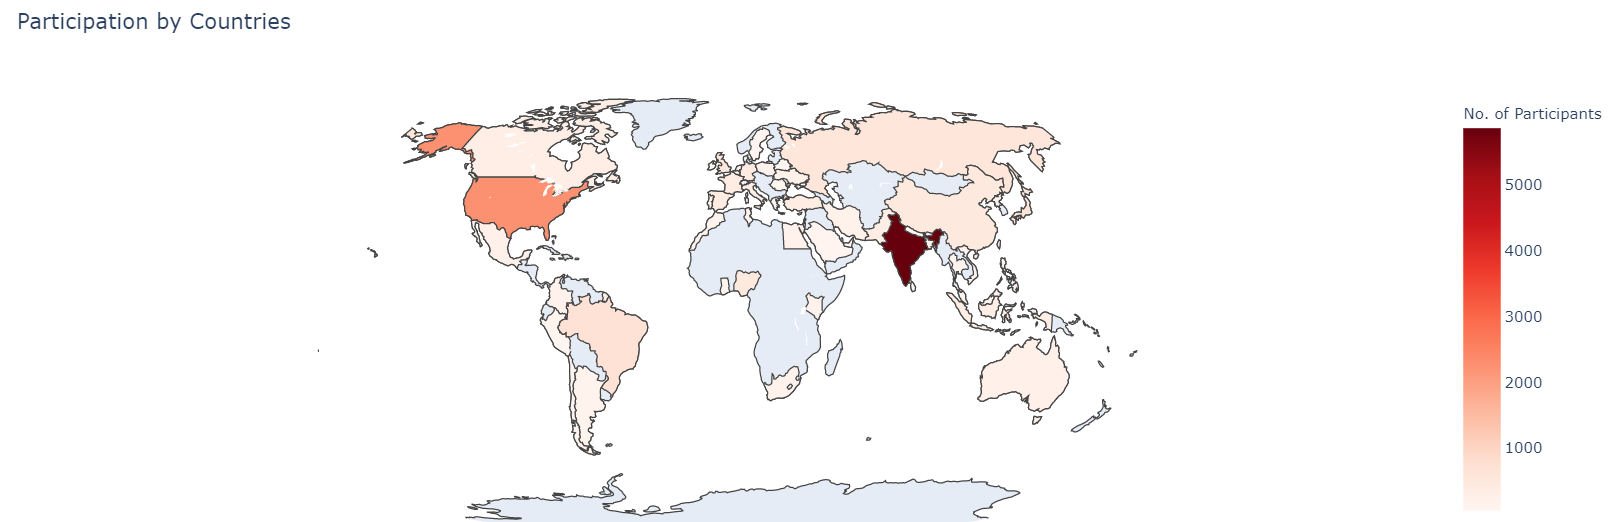

In [ ]:
# fuzzy search for country codes
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

# Change South Korea and Iran to their recognized names
data['Country'] = data['Country'].replace('South Korea', 'Korea')   
data['Country'] = data['Country'].replace('Iran, Islamic Republic of...', 'Iran')   

# group by countries, fetch codes
country_data = data['Country'].value_counts().rename_axis('Country').reset_index(name='Participants')
country_data['Country_Code'] = country_data['Country'].apply(lambda country: do_fuzzy_search(country))

# delete 'Other'
country_data = country_data[country_data.Country != 'Other']

# display(country_data.isnull().sum())

# plot map
map_data = [dict(type = 'choropleth', 
                 locations = country_data['Country_Code'],
#                  locationmode = 'country names', 
                 z = country_data['Participants'], 
                 text = country_data['Country'],
                 colorscale = 'Reds', 
                 colorbar = dict(title = 'No. of Participants'))]

map_layout = dict(title = 'Participation by Countries',
             geo = dict(showframe = False, 
                        projection = {'type':'natural earth'}))

fig = dict(data = map_data, layout = map_layout)
# fig = go.Figure(data = map_data, layout = map_layout)
# fig.show()
iplot(fig)


# Participation by Country and Gender
* Chart - Participation by Country and Gender : Shows top 5 and bottom 5 country-wise men and women participation w.r.t the differences between them. 
* There is no country where more women have participated than men, which verifies that there is less women in technology field as ever.

In [ ]:
# count all genders country wise
country_gender = data[['Country','Gender']].value_counts().unstack().reset_index()

# drop other insignificant genders except man and woman 
country_gender = country_gender.drop(['Nonbinary', 'Prefer not to say', 'Prefer to self-describe'], axis=1)
country_gender = country_gender[country_gender.Country != 'Other']

# calculate the difference column
country_gender['Difference'] = country_gender['Man'] - country_gender['Woman']
# country_gender.head()

# select 5 top and 5 bottom countires w.r.t differences in man and woman participant
sliced_data = pd.concat([country_gender.sort_values(by=['Difference'], ascending = False)[:5], 
                            country_gender.sort_values(by=['Difference'])[:5]])
# plot
fig2 = go.Figure(
    data=[
        go.Bar(
            name='Male Participants',
            x=sliced_data['Country'],
            y=sliced_data['Man'],
            offsetgroup=0,
        ),
        go.Bar(
            name='Female Participants',
            x=sliced_data['Country'],
            y=sliced_data['Woman'],
            offsetgroup=1,
        ),
        go.Bar(
            name='Difference',
            x=sliced_data['Country'],
            y=sliced_data['Difference'],
            offsetgroup=2,
        ),
    ],
    layout=go.Layout(
        title='Participation by Country and Gender',
        yaxis_title='Number of Participants'
    )
)
fig2.show()

# Participation by Age, Education, Coding Experiences and Designations
**Age** - 25 to 29 wins closely followed by (22 to 25) and (18 to 22)

**Education** - Master's Degree represents highest number of participants but it is tricky since the questions also involved "what they are planning to do" - which means maybe most students do not have masters right now but they are planning to do one. Same applied for Doctorate as well.

**Coding Experience** - Most participants have 1 to 5 years of experiences in coding

**Designations** - Majority of the participants are students, but that could mean students are doing a Master's degree

In [ ]:
# group by age and plot
age_data = data['Age'].value_counts()
plt.subplot(2, 2, 1)
age_data.plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6), figsize=(10, 10), rot=30)
plt.xlabel("Age", labelpad=14)
plt.ylabel("Count of People by age", labelpad=15)
plt.title('Participation by Age', y=1)  

# group by education and plot
edu_data = data['Education'].value_counts()
plt.subplot(2, 2, 2)
edu_data.plot(kind='barh', color=(0.2, 0.4, 0.6, 0.6), figsize=(10, 6))
plt.xlabel("Count of People", labelpad=15)
plt.title('Participation by Education', y=1)

# group by number of years coding and plot
coding_data = data['Years of Coding'].value_counts()
plt.subplot(2, 2, 3)
coding_data.plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6), figsize=(10, 10), rot=30)
plt.xlabel("Years", labelpad=14)
plt.ylabel("Count of People by coding exp.", labelpad=15)
plt.title('Participants by Coding Experiences', y=1)

# group by designation and plot
role_data = data['Current/Recent Title'].value_counts()
total_roles = role_data.sum()
role_data = round((role_data/total_roles)*100,1)
plt.subplot(2, 2, 4)
role_data.plot(kind='barh', color=(0.2, 0.4, 0.6, 0.6), figsize=(10, 10))
plt.xlabel("Count of People", labelpad=15)
plt.title('Participants with Popular Designations ', y=1)

plt.tight_layout(rect=[2, 0.02, 4, 0.8])
plt.show()

# Designation wise, we find the top languages, visualization libraries, notebooks and IDEs used
**Popular Language** - Python, R and SQL

**Popular IDE** - Jupyter Products and RStudio

**Popular Notebooks** - Kaggle and Colab

**Popular Vizualization** - Matplotlib and ggplot


In [ ]:
lang_cols = ['Current/Recent Title','Python','R','SQL','C','C++','Java','Javascript','Julia','Swift','Bash','MATLAB']
ide_cols = ['Current/Recent Title','Jupyter Products','RStudio','Visual_Studio','VSCode','PyCharm','Spyder','Notepad','Sublime','Vim/emacs','Matlab']
notebk_cols = ['Current/Recent Title','Kaggle','Colab','Azure','Paperspace','Binder','Code Ocean','IBM Watson','Amazon_Sagemaker','Amazon_EMR','Google Cloud AI','Google Cloud Datalab','Databricks']
viz_cols = ['Current/Recent Title','Matplotlib','Seaborn','Plotly/Plotly Express','Ggplot/ggplot2','Shiny','D3','Altair','Bokeh','Geoplotlib','Leaflet/Folium']

lang_d = data.loc[:, data.columns.isin(lang_cols)].copy()
ide_d = data.loc[:, data.columns.isin(ide_cols)].copy()
notebk_d = data.loc[:, data.columns.isin(notebk_cols)].copy()
viz_d = data.loc[:, data.columns.isin(viz_cols)].copy()

# replace Nan values with 0, else 1
lang_d[lang_cols[1:]] = lang_d[lang_cols[1:]].applymap(lambda x: 0 if pd.isnull(x) else 1)
ide_d[ide_cols[1:]] = ide_d[ide_cols[1:]].applymap(lambda x: 0 if pd.isnull(x) else 1)
notebk_d[notebk_cols[1:]] = notebk_d[notebk_cols[1:]].applymap(lambda x: 0 if pd.isnull(x) else 1)
viz_d[viz_cols[1:]] = viz_d[viz_cols[1:]].applymap(lambda x: 0 if pd.isnull(x) else 1)

# group by and sum 
lang_d = lang_d.groupby(cols[0]).sum()
ide_d = ide_d.groupby(cols[0]).sum()
notebk_d = notebk_d.groupby(cols[0]).sum()
viz_d = viz_d.groupby(cols[0]).sum()


# Find the largest value for each row
lang_d = lang_d.idxmax(axis=1).rename_axis('Designation').reset_index(name = 'Popular Language')
ide_d = ide_d.idxmax(axis=1).rename_axis('Designation').reset_index(name = 'Popular IDE')
notebk_d = notebk_d.idxmax(axis=1).rename_axis('Designation').reset_index(name = 'Popular Notebooks')
viz_d = viz_d.idxmax(axis=1).rename_axis('Designation').reset_index(name = 'Popular Vizualization')

# merge dataframes
joined1 = pd.merge(lang_d, ide_d, on='Designation')
joined2 = pd.merge(notebk_d, viz_d, on='Designation')
joined = pd.merge(joined1, joined2, on='Designation')

joined


# Popular Languages Used and Recommended to Learn

In [ ]:
# Languages used commonly
lan_used = data.iloc[:, 6:19].applymap(lambda x: 0 if pd.isnull(x) else 1).sum().sort_values(ascending=False).rename_axis('Languages').reset_index(name='Used')
total = sum(lan_used.Used)
text = lan_used['Used'].apply(lambda x: str(round(x/total*100,1))+'%')

# Languages recommended to learn
recom = data['Recommended Languages'].value_counts().rename_axis('Languages').reset_index(name='Recommended')
total1 = sum(recom.Recommended)
text1 = recom['Recommended'].apply(lambda x: str(round(x/total1*100,1))+'%')

# Merge the dataframes
Merged = pd.merge(lan_used, recom, on='Languages')

# plot charts
go.Figure(
    data=[
        go.Bar(
            name='Popularly Used Languages',
            x=Merged.Languages, y=Merged.Used,
            text=text,
            textposition='outside',
            offsetgroup=0,
        ),
        go.Bar(
            name='Recommended Languages',
            x=Merged.Languages, y=Merged.Recommended,
            text=text1,
            textposition='outside',
            offsetgroup=1,
        )],
    layout=go.Layout(
        title='Participation by Country and Gender',
        yaxis_title='Number of Participants'
    )
)